### Purpose of Exploration

#### Lending Club Intro: 

A peer to peer lending platform for small loans. At a top level both lenders and borro

We explore loans originated by every combo of vintage and Grade in a format described below

| Grade/Vintage | A    | B    | C    | D    | E    | F    | G    |
|---------------|------|------|------|------|------|------|------|
|               | 07Q1 | 07Q1 | 07Q1 | 07Q1 | 07Q1 | 07Q1 | 07Q1 |
|               | 07Q2 | 07Q2 | 07Q2 | 07Q2 | 07Q2 | 07Q2 | 07Q2 |
|               | 07Q3 | 07Q3 | 07Q3 | 07Q3 | 07Q3 | 07Q3 | 07Q3 |
|               | 07Q4 | 07Q4 | 07Q4 | 07Q4 | 07Q4 | 07Q4 | 07Q4 |
|               | ...  | ...  | ...  | ...  | ...  | ...  | ...  |

wers have access to their credit score as determined by Lending Club. Obviously lower grade of credit results in higher return. Typically loans orignated during different times come with different level of returns. This makes it hard to have a metric to compare loans across credit level excluding the impact of when the loan was originated.

We aim to analyze the realized return/volatility for each one of these vintage by grade combinations to see if we uncover any insight.

In [1]:
import numpy as np
import os
import pandas as pd
from scipy import stats
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.weightstats import DescrStatsW
from scipy.optimize  import brentq,minimize,fsolve
import warnings
import pickle
warnings.filterwarnings("ignore")
import pandas as pd
import zipfile
import numpy as np

In [3]:

def wavg(group, avg_name, weight_name):
    """
    Parameters
    ----------
    group: DataFrame
     * DataFrame containing the weights and series to average
    avg_name: str
     * name of column that we want to average out by
    weight_name: str
     * name of column that we want to weight by when averaging
    
    Returns
    -------
    The weighted average of the series (avg_name) weighted by (weight_name)
    
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
def monthlyRet(pmtSampl):
    """
    Parameters
    ----------
    pmtSampl: DataFrame
     * DataFrame containing the sample of the payment history data
    Returns
    -------
    * Dataframe that describes the cashflow from the payment extract (pmtSample) by month
    All relevant Cashflows from the loan pool are cumulatively summed over months
    Relvant Columns:
        * totCF=PRNCP_PAID + INT_PAID - princLost + PCO_RECOVERY -PCO_COLLECTION_FEE
        * remTerm: 
    """
    byMonth=pmtSampl.groupby(['MONTH'])[['PBAL_BEG_PERIOD','PRNCP_PAID','INT_PAID','PCO_RECOVERY','PCO_COLLECTION_FEE','princLost']].sum()
    byMonthTerm=pmtSampl.groupby(['MONTH']).apply(wavg, "remTerm", "PBAL_BEG_PERIOD")
    byMonth=pd.concat([byMonth,byMonthTerm.rename('remTerm')],axis=1)
    byMonth['totCF']=byMonth['PRNCP_PAID']+byMonth['INT_PAID']-byMonth['princLost']+byMonth['PCO_RECOVERY']-byMonth['PCO_COLLECTION_FEE']
    byMonth.index=list(map(lambda x: datetime.datetime.strptime(x, '%b%Y'),byMonth.index))
    byMonth=byMonth.sort_index()
    return byMonth

def npv_f( cashflows,rate):
    """
    Parameters
    ----------
    cashflows: array
     * array that contains cashflows
    rate: float
    * rate to discount by
    
    Returns
    -------
    * float that represents every cashflow discounted back to Time 0 by the rate specified
    """
    total = 0.0
    for i, cashflow in enumerate(cashflows):
        total += cashflow / (1 + rate)**i
    return total
def rateSolver(PV,cashflows):
    """
    Parameters
    ----------
    PV: float
     * PV of all cashflows
    cashflows: array
     * array that contains cashflows
     
    Returns
    -------
    * float that represents YTM of the cahsflows to achieve the PV
    """
    return (fsolve(lambda r: (PV-npv_f(cashflows,r))**2,0.02))[0]

In [ ]:
zf = zipfile.ZipFile('All_Payments_2019_02.zip')
relCol=['LOAN_ID','DUE_AMT','PBAL_BEG_PERIOD','PRNCP_PAID','INT_PAID','PCO_RECOVERY','PCO_COLLECTION_FEE','PERIOD_END_LSTAT','MONTH','VINTAGE','term','MOB','grade']
allDF = pd.read_csv(zf.open('PMTHIST_ALL_201902.csv'),usecols=relCol)
# PmtHistDF=allDF.sample(20000000)
PmtHistDF=allDF

### Additional Columns added to payment history:

1) remTerm: approximates the term remaining for the loan (in months) as the original principal outstanding as term - months since origination
    
2) princLost: approximates the amount of principal lost as per the amount of principal outstandng of charged off loans


In [369]:

PmtHistDF['remTerm']=[*map(lambda x: max(x) ,zip(np.ones(len(PmtHistDF)),PmtHistDF['term']-PmtHistDF['MOB']))]
PmtHistDF['princLost']=PmtHistDF['PBAL_BEG_PERIOD']*(PmtHistDF['PERIOD_END_LSTAT']=='Charged Off')

Vintages=PmtHistDF['VINTAGE'].unique()
Vintages.sort()

In [371]:
byMonth.head()
byMonth=Vintagedata['11Q3']
byMonth=byMonth.iloc[12:]
begPrinc=byMonth['PBAL_BEG_PERIOD'][0]

endPrinc=byMonth['PBAL_BEG_PERIOD'][-1]
princ=begPrinc-endPrinc
r=rateSolver(princ,byMonth['totCF'])
r,princ,npv_f(byMonth['totCF'],r)
byMonth['remTerm'][0]

44.56278248836892

### Sample loans by vintage and grade combo

We look at loans of every grade by their vintage of origination and their. We monitor these loans by looking at their performance on an accregated monthly basis using function (monthRet).

We describe the cashflow from the payment extract (every grade by vintage subset of loans) by month. All relevant Cashflows from the loan pool are cumulatively summed over months

##### Relvant Additional Columns:

    * totCF=PRNCP_PAID + INT_PAID - princLost + PCO_RECOVERY -PCO_COLLECTION_FEE

    * remTerm: the length of term of all loans in the vintage/grade subset 


Once we have our monthly summary dataframe, we look at the following:
    * princ: principal outstanding for every vintage after it ramps up (3 month for every quarter)
    * r: rate that solves as the YTM observed to equate the precent value of all cashflows from the pool of loans from the vintage/grade combo
    

In [378]:
vintageSummarybyGrade={}
for grd in grades:
    print(grd)
    listRates=[]
    listPrinc=[]
    listRemTerm=[]
    data=PmtHistDF.loc[PmtHistDF['grade']==grd]
    Vintagedata={}
    for vint in Vintages[:-4]:
        try:
            byMonth=Vintagedata[vint]
        except:
            byMonth=monthlyRet(data.loc[(PmtHistDF['VINTAGE']==vint)])
            Vintagedata[vint]=byMonth
        if len(byMonth)>3:
            byMonth=byMonth.iloc[3:]
            begPrinc=byMonth['PBAL_BEG_PERIOD'][0]

            endPrinc=byMonth['PBAL_BEG_PERIOD'][-1]
            princ=begPrinc-endPrinc
            r=rateSolver(princ,byMonth['totCF'])
            remTerm=byMonth['remTerm'][0]
        else:
            r=np.nan
            princ=np.nan
            remTerm=np.nan
        listRates.append(r)
        listPrinc.append(princ)
        listRemTerm.append(remTerm)
    vintageSummary=pd.DataFrame(data=np.array([listRates,listPrinc,listRemTerm]).T,columns=['IRR','Vintage Principal','RemTerm'],index=Vintages[:-4])
    vintageSummarybyGrade[grd]=vintageSummary
        
grades=list(vintageSummarybyGrade.keys())      

C
B
A
D
F
E
G


In [4]:
#### Only use this to save results as pickle


# with open('vintageSummarybyGradeUse.pickle', 'wb') as handle:
#     pickle.dump(vintageSummarybyGrade, handle, protocol=pickle.HIGHEST_PROTOCOL)
# vintageSummarybyGrade = pickle.load( open( "vintageSummarybyGradeUse.pickle", "rb" ) )
# grades=list(vintageSummarybyGrade.keys()) 

#### We Summarize performance of all vitnages by their grade below (look at implied IRR, Amount/Principal Originated and WAL of loans orignated)

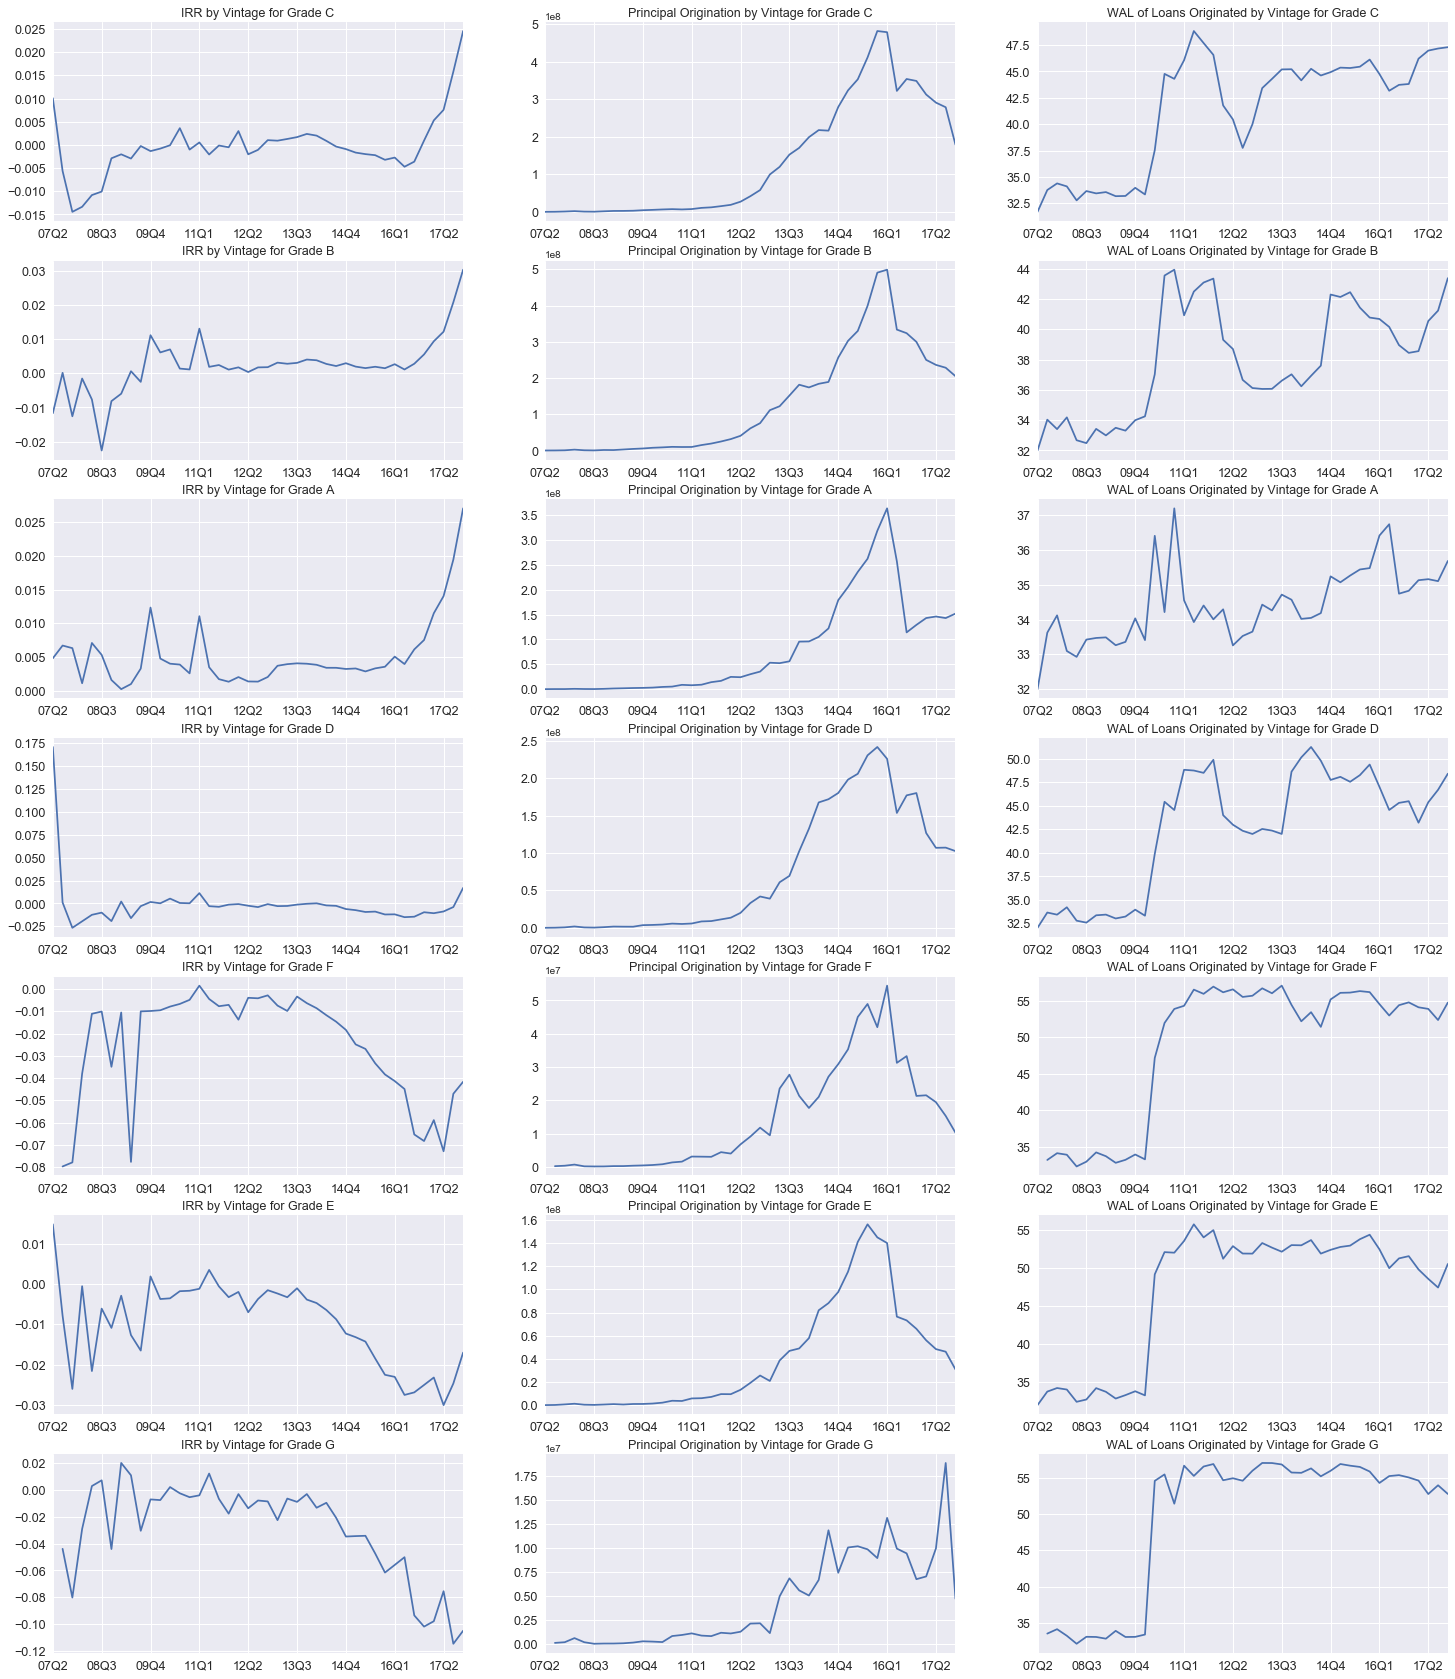

In [5]:
sns.set()
fig,axLst=plt.subplots(7,3,figsize=(25,10*3))
axInd=0
for grd in grades:
    ax=(axLst.flatten())[axInd]
    vintageSummarybyGrade[grd]['IRR'].plot(ax=ax,title='IRR by Vintage for Grade {}'.format(grd))
    axInd+=1
    ax=(axLst.flatten())[axInd]
    vintageSummarybyGrade[grd]['Vintage Principal'].plot(ax=ax,title='Principal Origination by Vintage for Grade {}'.format(grd))
    axInd+=1
    ax=(axLst.flatten())[axInd]
    vintageSummarybyGrade[grd]['RemTerm'].plot(ax=ax,title='WAL of Loans Originated by Vintage for Grade {}'.format(grd))
    axInd+=1
for axes in axLst.flatten():
    for item in ([axes.title, axes.xaxis.label, axes.yaxis.label] +axes.get_xticklabels() + axes.get_yticklabels()):
        item.set_fontsize(12.5)
plt.show()

#### Risk/Return Analysis by Grade

We have realized return for all vintages (from 07Q1 - 17Q4) by grades. Hence we can define Volatility as volatility/standard deviation of IRRs over all vintages.

We surprisingly see that by realized return and realized volatility metric, grade A loans seems to provide the best "realized" Sharpe Ratio comes from A,B and C Grade Loans originated throughout all vintages.

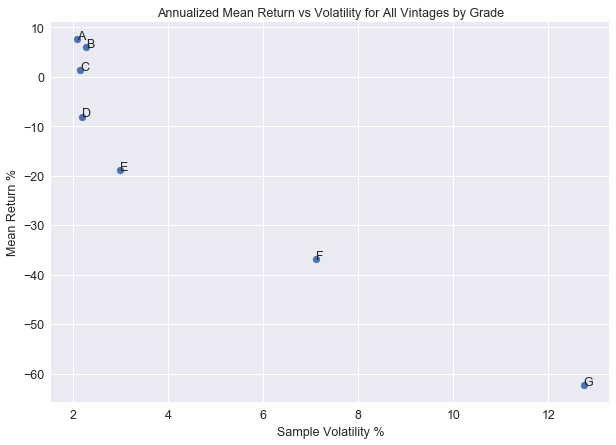

,Monthly Mean Return,Monthly Volatility,Annualized SharpeRatio
C,0.001080,0.006223,0.601052
B,0.005005,0.006588,2.631409
A,0.006337,0.006019,3.647003
D,-0.006725,0.006335,-3.677196
F,-0.030659,0.020538,-5.171256
E,-0.015720,0.008595,-6.336244
G,-0.051916,0.036802,-4.886696


In [14]:
summariesByGrades=[]
for grd in grades:
    vS=vintageSummarybyGrade[grd].dropna()
    vS=vS.loc[np.abs(vS['IRR'])<1]
    weighted_stats = DescrStatsW(vS['IRR'], weights=vS['Vintage Principal'], ddof=0)
    summariesByGrades.append([weighted_stats.mean,weighted_stats.std])
gradeSummReturns=pd.DataFrame(data=np.array(summariesByGrades),index=grades,columns=['Monthly Mean Return','Monthly Volatility'])

sns.set()
fig, ax = plt.subplots(figsize=(10,7))
y=gradeSummReturns['Monthly Mean Return']*100*12
x=gradeSummReturns['Monthly Volatility']*100*np.sqrt(12)
ax.scatter(x,y)

for i, txt in enumerate(gradeSummReturns.index):
    ax.annotate(txt, (x[i], y[i]),size=12.5)
ax.set_title('Annualized Mean Return vs Volatility for All Vintages by Grade')
ax.set_xlabel('Sample Volatility %')
ax.set_ylabel('Mean Return %')
for axes in [ax]:
    for item in ([axes.title, axes.xaxis.label, axes.yaxis.label] +axes.get_xticklabels() + axes.get_yticklabels()):
        item.set_fontsize(12.5)
plt.show()
gradeSummReturns['Annualized SharpeRatio']=y/x
gradeSummReturns